# Variational inference using the finite approximation

trying cavi + annealing

In [73]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [74]:
# np.random.seed(12321) # this is a seed where annealing works well 
# np.random.seed(43141) # this is a seed that works well too :)
# np.random.seed(341708970) # this too!

# np.random.seed(14314) 
np.random.seed(4234) # this less so ...

# np.random.seed(123414) # this one is pretty meh -- gets one column absolutely correct # stull better than CAVI though



Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([Num_samples,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
#print(mu)
#print(sigma_A*np.identity(D))
#print(K_inf)
#A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?
A = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))
print(A)

# draw noise
# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)
epsilon = np.random.normal(0, sigma_eps, (Num_samples, D))

# the observed data
X = np.dot(Z,A) + epsilon


true Z (first 10 rows): 
 [[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
[[ -4.94188276 -20.26363075]
 [  7.72169227 -14.61881616]
 [ -2.47579307  13.17264379]]


# set initializations

In [75]:
K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000
elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)


Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}


In [76]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)

# run CAVI

In [77]:
#add_noise_to_phi(phi_mu, 1.0)
#sigma_eps_anneal = np.linspace(100, sigma_eps, 100)

phi_mu_traj1 = np.zeros([10 * 1000 , 2])
phi_mu_traj2 = np.zeros([10 * 1000 , 2])
phi_mu_traj3 = np.zeros([10 * 1000 , 2])



sigma_eps_anneal = np.linspace(100, sigma_eps, 10)

total_iter = 0
for j in range(len(sigma_eps_anneal)): 
    total_iter += 1
    
    sigmas['eps'] = sigma_eps_anneal[j]
    print('anneal iteration: ', j, 'sigma_eps', sigmas['eps'])
    
    tol = [10**(-2)]* 2 + [10**(-4)]*3 + [10**(-6)]*3 + [10**(-8)]*2 # set sequence of tolerances
    #tol = [10**(-1)]*90 + [10**(-2)]* 2  + [10**(-4)]*3 + [10**(-6)]*3 + [10**(-8)]*2
    assert len(tol) == len(sigma_eps_anneal)
    
    elbo = np.zeros(iterations)
    
    for i in range(iterations):
        
        cavi_updates(tau, nu, phi_mu, phi_var, X, alpha, sigmas)
        
        phi_mu_traj1[total_iter - 1, :] = phi_mu[:,0]
        phi_mu_traj2[total_iter - 1, :] = phi_mu[:,1]
        phi_mu_traj3[total_iter - 1, :] = phi_mu[:,2]
        
        print(phi_mu_traj1)
        # round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

        [elbo[i],elbo_Term1[i],elbo_Term2[i],elbo_Term3[i],elbo_Term4[i],elbo_Term5[i],elbo_Term6[i],\
         elbo_Term7[i]] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)

        if i%10 ==0:
            nice_iter_display = str(j)+'-'+str(i) # anneal_iter - cavi_iter
            print('iteration: ', nice_iter_display, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), \
                 'elbo: ', elbo[i])
        #print(round_nu[0:10,:])
        #print(nu[0:10,:])
        #print('l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]) )

        if np.isnan(elbo[i]):
            print('NAN ELBO.')
            break

        if (i>0) & (elbo[i] < elbo[i-1]): 
            print('elbo decreased!  Difference: ', elbo[i] - elbo[i-1])
            print(i)
            print(elbo[0:i+1])
            break
    
        if np.abs(elbo[i]-elbo[i-1]) <= tol[j]:
            print('ELBO converged ; iterations ran: ', i, '\n')
            break


anneal iteration:  0 sigma_eps 100.0
[[  0.25535097 -16.97766203]
 [  0.           0.        ]
 [  0.           0.        ]
 ..., 
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]
iteration:  0-0  l1 error:  0.637716455188 elbo:  -3827.88714288
[[  0.30913868 -19.88199239]
 [  0.           0.        ]
 [  0.           0.        ]
 ..., 
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]
[[  0.27510635 -19.89926645]
 [  0.           0.        ]
 [  0.           0.        ]
 ..., 
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]
[[  0.27201167 -19.83057923]
 [  0.           0.        ]
 [  0.           0.        ]
 ..., 
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]
[[  0.27338899 -19.77402818]
 [  0.           0.        ]
 [  0.           0.        ]
 ..., 
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0

KeyboardInterrupt: 

Z (unpermuted): 
 [[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
** procedure did not give a true permutation
permutation:  [2, 1, 0]
Z (permuted) 
 [[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
round_nu 
 [[ 0.  1.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]]
l1 error (after permutation):  [0.92200000000000004, 0.16400000000000001, 9.5138307514948965e-229]


true A (permuted): 
 [[ -2.47579307  13.17264379]
 [  7.72169227 -14.61881616]
 [ -4.94188276 -20.26363075]]
phi_mu: 
 [[  2.79361416 -13.2498268 ]
 [  7.46563094 -14.56464988]
 [ -7.48991568  -7.05679823]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.15135492  0.69861203  0.79576999]


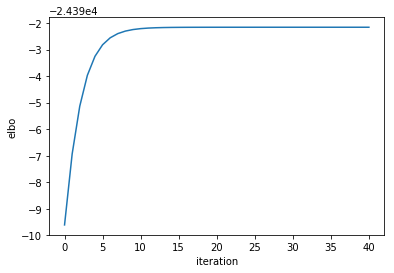

In [32]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [2,1,0]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

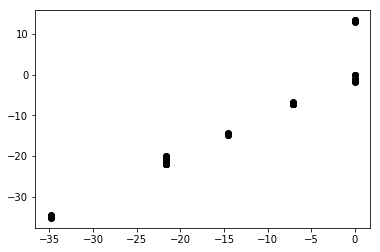

In [35]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

In [109]:
# let us permute the columms of nu and then compare: 
nu_perm = nu[:, (1,2,0)]
round_nu_perm = np.round(nu_perm*(nu_perm>=0.9) + nu_perm*(nu_perm<=0.1)) + nu_perm*(nu_perm>=0.1)*(nu_perm<=0.9)

print(np.sum(np.abs(Z[:,0] - nu_perm[:,0]))/Num_samples)
print(np.sum(np.abs(Z[:,1] - nu_perm[:,1]))/Num_samples)
print(np.sum(np.abs(Z[:,2] - nu_perm[:,2]))/Num_samples)

# so two of the rows are really close ...

0.9566
0.1538
0.706
